<CENTER><img src="../../images/ATLASOD.gif" style="width:50%"></CENTER>

# How to rediscover the Higgs boson yourself!
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to rediscover the Higgs boson yourself!

The idea is that cuts increase the ratio of signal ($H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$) to background ($Z, t\bar{t}, ZZ \rightarrow \ell\ell\ell\ell$)

First, the amount of $Z$ and $t\bar{t}$ background is reduced, since these are quite different to the signal.

Then, the amount of $ZZ \rightarrow \ell\ell\ell\ell$ is reduced, whilst keeping $H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$ signal

The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so that processing is quicker.

This analysis loosely follows the discovery of the Higgs boson by ATLAS https://arxiv.org/pdf/1207.7214.pdf (mostly Section 4 and 4.1)

Feynman diagram pictures are borrowed from our friends at https://www.particlezoo.net

<CENTER><img src="HZZ_feynman.png" style="width:40%"></CENTER>

## First time setup on your computer (no need on mybinder)
This first cell only needs to be run the first time you open this notebook on your computer. 

If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.

If you open on mybinder, you don't need to run this cell.

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer
!{sys.executable} -m pip install uproot pandas numpy matplotlib --user # install required packages

## To setup everytime
Cell -> Run All Below

to be done every time you re-open this notebook

In [10]:
import uproot # for reading .root files
import pandas as pd # to store data as dataframe
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
import concurrent.futures # for parallel file reading
from matplotlib.ticker import AutoMinorLocator # for minor ticks

import infofile # locla file containing info on cross-sections, sums of weights, dataset IDs
import labelfile # local file containing plot labels

General definitions of luminosity, fraction of data used, where to access the input files

In [11]:
#lumi = 0.5 # fb-1 # data_A only
#lumi = 1.9 # fb-1 # data_B only
#lumi = 2.9 # fb-1 # data_C only
#lumi = 4.7 # fb-1 # data_D only
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

fraction = 0.9 # reduce this is you want the code to run quicker
                                                                                                                                  
#tuple_path = "Input/4lep/" # local 
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/" # web address

samples to process

In [20]:
samples = {

    'data': {
        'list' : ['data_A','data_B','data_C','data_D']
    },

    r'$Z,t\bar{t}$' : { # Z + ttbar
        'list' : ['Zee','Zmumu','ttbar_lep'],
        'color' : "#6b59d3" # purple
    },

    'ZZ' : {
        'list' : ['llll'],
        'color' : "#ff0000" # red
    },

    r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$' : { # H -> ZZ -> llll
        'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep','WH125_ZZ4lep','ZH125_ZZ4lep'],
        'color' : "#00cdff" # light blue
    }

}

Define function to get data from files

In [21]:
def get_data_from_files():

    data = {}
    for s in samples:
        print('Processing '+s+' samples')
        frames = []
        for val in samples[s]['list']:
            prefix = "MC/mc_"
            if s == 'data':
                prefix = "Data/"
            else: prefix += str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".4lep.root"
            if fileString != "":
                temp = read_file(fileString,val)
                frames.append(temp)
            else:
                print("Error: "+val+" not found!")
        data[s] = pd.concat(frames)
    
    return data

define function to calculate weight of MC event

In [22]:
def calc_weight(mcWeight,scaleFactor_PILEUP,scaleFactor_ELE,
                scaleFactor_MUON, scaleFactor_LepTRIGGER):
    return mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_LepTRIGGER

define function to get cross-section weight

In [23]:
def get_xsec_weight(totalWeight,sample):
    info = infofile.infos[sample]
    weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    weight *= totalWeight
    return weight

define function to calculate 4-lepton invariant mass

In [24]:
def calc_mllll(lep_pt,lep_eta,lep_phi,lep_E):
    # first lepton is [0], 2nd lepton is [1] etc
    px_0 = lep_pt[0]*math.cos(lep_phi[0]) # x-component of lep[0] momentum
    py_0 = lep_pt[0]*math.sin(lep_phi[0]) # y-component of lep[0] momentum
    pz_0 = lep_pt[0]*math.sinh(lep_eta[0]) # z-component of lep[0] momentum
    px_1 = lep_pt[1]*math.cos(lep_phi[1]) # x-component of lep[1] momentum
    py_1 = lep_pt[1]*math.sin(lep_phi[1]) # y-component of lep[1] momentum
    pz_1 = lep_pt[1]*math.sinh(lep_eta[1]) # z-component of lep[1] momentum
    px_2 = lep_pt[2]*math.cos(lep_phi[2]) # x-component of lep[2] momentum
    py_2 = lep_pt[2]*math.sin(lep_phi[2]) # y-component of lep[2] momentum
    pz_2 = lep_pt[2]*math.sinh(lep_eta[2]) # z-component of lep[3] momentum
    px_3 = lep_pt[3]*math.cos(lep_phi[3]) # x-component of lep[3] momentum
    py_3 = lep_pt[3]*math.sin(lep_phi[3]) # y-component of lep[3] momentum
    pz_3 = lep_pt[3]*math.sinh(lep_eta[3]) # z-component of lep[3] momentum
    sumpx = px_0 + px_1 + px_2 + px_3 # x-component of 4-lepton momentum
    sumpy = py_0 + py_1 + py_2 + py_3 # y-component of 4-lepton momentum
    sumpz = pz_0 + pz_1 + pz_2 + pz_3 # z-component of 4-lepton momentum
    sumE = lep_E[0] + lep_E[1] + lep_E[2] + lep_E[3] # energy of 4-lepton system
    return math.sqrt(sumE**2 - sumpx**2 - sumpy**2 - sumpz**2)/1000 #/1000 to go from MeV to GeV

## Changing an already uncommented cut

If you change a cut: Cell -> Run All Below

If you uncomment a cut here, you also need to uncomment the corresponding cut in the cell above.

In [25]:
# cut on number of leptons
# paper: "selecting two pairs of isolated leptons"
def cut_lep_n(lep_n):
# exclamation mark (!) means "not"
# so != means "not equal to"
# throw away when number of leptons is not equal to 4 
    return lep_n != 4

# cut on lepton charge
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_charge(lep_charge):
# throw away when sum of lepton charges is not equal to 0
# first lepton is [0], 2nd lepton is [1] etc
    return lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] != 0

# cut on lepton type
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# throw away when none of eeee, mumumumu, eemumu
    sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3]
    return (sum_lep_type != 44) and (sum_lep_type != 48) and (sum_lep_type != 52)

#cut on transverse momentum of the leptons
# paper: " the second (third) lepton in pT order must satisfy pT > 15 GeV (pT > 10 GeV)"
def cut_lep_pt_012(lep_pt):
# throw away any events where lep_pt[1] < 15000
# throw away any events where lep_pt[2] < 10000
    return lep_pt[1] < 15000 or lep_pt[2] < 10000

## Uncommenting a new cut
If you add a cut: Cell -> Run All Below

In [26]:
def read_file(path,sample):
    start = time.time() # start the clock
    print("\tProcessing: "+sample) # print which sample is being processed
    data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample
    mc = uproot.open(path)["mini"] # open the tree called mini
    numevents = uproot.numentries(path, "mini") # number of events
    for data in mc.iterate(["lep_n","lep_pt","lep_eta","lep_phi","lep_E","lep_charge","lep_type","lep_ptcone30",
                            "lep_etcone20", # add more variables here if you make cuts on them 
                            "mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON",
                            "scaleFactor_LepTRIGGER"], # variables to calculate Monte Carlo weight
                           flatten=False, # make JaggedArrays lists
                           entrysteps=2500000, # number of events in a batch to process
                           outputtype=pd.DataFrame, # choose output type as pandas DataFrame
                           entrystop=numevents*fraction): # process up to numevents*fraction

        nIn = len(data.index) # number of events in this batch
        print('\t initial number of events:\t\t\t',nIn)

        if 'data' not in sample: # only do this for Monte Carlo simulation files
            # multiply all Monte Carlo weights and scale factors together to give total weight
            data['totalWeight'] = np.vectorize(calc_weight)(data.mcWeight,data.scaleFactor_PILEUP,
                                                            data.scaleFactor_ELE,data.scaleFactor_MUON,
                                                            data.scaleFactor_LepTRIGGER)
            # incorporate the cross-section weight into the total weight
            data['totalWeight'] = np.vectorize(get_xsec_weight)(data.totalWeight,sample)
            
        # drop the columns we don't need anymore from the dataframe
        data.drop(["mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON","scaleFactor_LepTRIGGER"], 
                  axis=1, inplace=True)

        # cut on number of leptons using the function cut_lep_n defined above
        fail = data[ np.vectorize(cut_lep_n)(data.lep_n)].index
        data.drop(fail, inplace=True)
        print('\t after requiring 4 leptons:\t\t\t',len(data.index))

        # cut on lepton charge using the function cut_lep_charge defined above
        fail = data[ np.vectorize(cut_lep_charge)(data.lep_charge) ].index
        data.drop(fail, inplace=True)
        print('\t after requiring zero net charge:\t\t',len(data.index))

        # cut on lepton type using the function cut_lep_type defined above
        fail = data[ np.vectorize(cut_lep_type)(data.lep_type) ].index
        data.drop(fail, inplace=True)
        print('\t after requiring lepton pairs of same type:\t',len(data.index))

        #cut on the transverse momentum of the leptons using the function cut_lep_pt_012 defined above
        fail =data[ np.vectorize(cut_lep_pt_012)(data.lep_pt)].index
        data.drop(fail,inplace=True)
        print('\t after requirements on lepton pt:\t\t',len(data.index))

        # calculation of 4-lepton invariant mass using the function calc_mllll defined above
        data['mllll'] = np.vectorize(calc_mllll)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_E)

        # dataframe contents can be printed at any stage like this
        #print(data)

        # dataframe column can be printed at any stage like this
        #print(data['lep_pt'])

        # multiple dataframe columns can be printed at any stage like this
        #print(data[['lep_pt','lep_eta']])

        nOut = len(data.index) # number of events passing cuts in this batch
        data_all = data_all.append(data) # append dataframe from this batch to the dataframe for the whole sample
        elapsed = time.time() - start # time taken to process
        print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
    
    return data_all # return dataframe containing events passing all cuts

This is where the processing happens

In [27]:
start = time.time() # time at start of whole processing
data = get_data_from_files() # process all files
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Processing data samples
	Processing: data_A
	 initial number of events:			 3
	 after requiring 4 leptons:			 3
	 after requiring zero net charge:		 2
	 after requiring lepton pairs of same type:	 2
	 after requirements on lepton pt:		 2
		 nIn: 3,	 nOut: 	2	 in 0.2s
	Processing: data_B
	 initial number of events:			 12
	 after requiring 4 leptons:			 12
	 after requiring zero net charge:		 8
	 after requiring lepton pairs of same type:	 7
	 after requirements on lepton pt:		 6
		 nIn: 12,	 nOut: 	6	 in 0.2s
	Processing: data_C
	 initial number of events:			 18
	 after requiring 4 leptons:			 18
	 after requiring zero net charge:		 12
	 after requiring lepton pairs of same type:	 11
	 after requirements on lepton pt:		 10
		 nIn: 18,	 nOut: 	10	 in 0.2s
	Processing: data_D
	 initial number of events:			 32
	 after requiring 4 leptons:			 32
	 after requiring zero net charge:		 21
	 after requiring lepton pairs of same type:	 14
	 after requirements on lepton pt:		 14
		 nIn: 32,	 nOut: 

## Make a change to plotting
If you only want a make a change in plotting: Cell -> Run All Below

In [28]:
mllll = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':5, # width of each histogram bin
    'num_bins':34, # number of histogram bins
    'xrange_min':80, # minimum on x-axis

    # change aesthetic parameters if you want
    'y_label_x_position':-0.09, # 0.09 to the left of y axis
    'linear_top_margin':1.4 # to decrease the separation between data and the top of the figure, pick a number closer to 1
}

hist_dict = {'mllll':mllll} # add a histogram here if you want it plotted

Define function to plot the data

In [37]:
def plot_data(data):

    plot_label = r'$H \rightarrow ZZ^* \rightarrow \ell\ell\ell\ell$' # label to write on the plot
    signal_label = 'Signal ($m_H=125$ GeV)' # signal label in legend
    signal = r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$' # which sample is the signal

    # *******************
    # general definitions (shouldn't need to change)
    lumi_used = str(lumi*fraction) # luminosity to write on the plot

    for x_variable,hist in hist_dict.items(): # access the dictionary of histograms defined in the cell above

        h_bin_width = hist['bin_width'] # get the bin width defined in the cell above
        h_num_bins = hist['num_bins'] # get the number of bins defined in the cell above
        h_xrange_min = hist['xrange_min'] # get the x-range minimum defined in the cell above
        h_y_label_x_position = hist['y_label_x_position'] # get the x-position of the y-axis label defined in the cell above
        h_linear_top_margin = hist['linear_top_margin'] # to decrease the separation between data and the top of the figure, pick a number closer to 1
    
        bins = [ h_xrange_min + x*h_bin_width for x in range(h_num_bins+1) ] # bin limits
        bin_centres = [ h_xrange_min+h_bin_width/2 + x*h_bin_width for x in range(h_num_bins) ] # bin centres

        data_x,_ = np.histogram( data['data'][x_variable].values, bins=bins ) # histogram the data
        data_x_errors = np.sqrt( data_x ) # statistical error on the data

        signal_x = data[signal][x_variable].values # histogram the signal
        signal_weights = data[signal].totalWeight.values # get the weights of the signal events
        signal_color = samples[signal]['color'] # get the colour for the signal bar
    
        mc_x = [] # define list to hold the Monte Carlo histogram entries
        mc_weights = [] # define list to hold the Monte Carlo weights
        mc_colors = [] # define list to hold the colors of the Monte Carlo bars
        mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars
        mc_x_tot = np.zeros( len(bin_centres) ) # define array of length bin_centres to hold the sum of MC bars

        for s in samples: # loop over samples
            if s not in ['data', signal]: # if not data nor signal
                mc_x.append( data[s][x_variable].values ) # append to the list of Monte Carlo histogram entries
                mc_weights.append( data[s].totalWeight.values ) # append to the list of Monte Carlo weights
                mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
                mc_labels.append( s ) # append to the list of Monte Carlo legend labels
                mc_x_heights,_ = np.histogram(data[s][x_variable].values, bins=bins,
                                              weights=data[s].totalWeight.values ) # histogram the current sample
                mc_x_tot = np.add( mc_x_tot, mc_x_heights ) # add to the array holding the total MC y-axis value
    
        mc_x_err = np.sqrt( mc_x_tot ) # statistical error on the Monte Carlo bars
    
    
        # *************
        # Main plot 
        # *************
        plt.clf() # clear figure
        plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height
        main_axes = plt.gca() # get current axes
        # plot the data points
        main_axes.errorbar( x=bin_centres, y=data_x, yerr=data_x_errors, fmt='ko', label='Data' ) 
        # plot the Monte Carlo bars
        mc_heights = main_axes.hist(mc_x, bins=bins, weights=mc_weights, stacked=True, color=mc_colors, 
                                    label=mc_labels )
        # plot the signal bar
        main_axes.hist(signal_x, bins=bins, bottom=mc_x_tot, weights=signal_weights, color=signal_color,
                       label=signal )
        # plot the statistical uncertainty
        main_axes.bar(bin_centres, # x
                      2*mc_x_err, # heights
                      alpha=0.5, # half transparency
                      bottom=mc_x_tot-mc_x_err, color='none', hatch="////", width=h_bin_width, 
                      label='Stat. Unc.' )
        
        main_axes.set_xlim( left=h_xrange_min, right=bins[-1] ) # set the x-limit of the main axes
        main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) # separation of x axis minor ticks
        # set the axis tick parameters for the main axes
        main_axes.tick_params(which='both', # ticks on both x and y axes
                              direction='in', # Put ticks inside and outside the axes
                              top=True, # draw ticks on the top axis
                              labeltop=False, # don't draw tick labels on top axis
                              labelbottom=False, # don't draw tick labels on bottom axis
                              right=True, # draw ticks on right axis
                              labelright=False ) # don't draw tick labels on right axis
        if len( labelfile.variable_labels[x_variable].split('[') ) > 1: # if x-axis has units
            y_units = ' '+labelfile.variable_labels[x_variable][labelfile.variable_labels[x_variable].find("[")+1:labelfile.variable_labels[x_variable].find("]")]
        else: y_units = '' # if x-axis is unitless
        main_axes.set_ylabel('Events / '+str(h_bin_width)+y_units, fontname='sans-serif',
                             horizontalalignment='right', y=1.0, fontsize=11 ) # write y-axis label for main axes
        # set y-axis limits for main axes
        main_axes.set_ylim( bottom=0, top=(np.amax(data_x)+math.sqrt(np.amax(data_x)))*h_linear_top_margin )
        main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) # add minor ticks on y-axis for main axes
        
        # Add text 'ATLAS Open Data' on plot
        plt.text(0.05, # x
                 0.97, # y
                 'ATLAS Open Data', # text
                 transform=main_axes.transAxes, # coordinate system used is that of main_axes
                 horizontalalignment='left', verticalalignment='top', family='sans-serif', fontsize=13 ) 
        # Add text 'for education' on plot
        plt.text(0.05, # x
                 0.9, # y
                 'for education', # text
                 transform=main_axes.transAxes, # coordinate system used is that of main_axes
                 horizontalalignment='left', verticalalignment='top', family='sans-serif', style='italic',
                 fontsize=8 ) 
        # Add energy and luminosity
        plt.text(0.05, # x
                 0.86, # y
                 '$\sqrt{s}=13\,\mathrm{TeV},\;\int L\,dt=$'+lumi_used+'$\,\mathrm{fb}^{-1}$', # text
                 transform=main_axes.transAxes, # coordinate system used is that of main_axes
                 horizontalalignment='left', verticalalignment='top', family='sans-serif' ) 
        # Add a label for the analysis carried out
        plt.text(0.05, # x
                 0.78, # y
                 plot_label, # text 
                 transform=main_axes.transAxes, # coordinate system used is that of main_axes
                 horizontalalignment='left', verticalalignment='top', family='sans-serif' )
    
        # Create new legend handles but use the colors from the existing ones 
        handles, labels = main_axes.get_legend_handles_labels()
    
        # specify order within legend
        new_handles = [ handles[labels.index('Data')] ] # first entry in legend is 'Data'
        new_labels = ['Data']
        for s in reversed( list( samples.keys() ) ): # loop over samples names
            if s not in ['data', signal]: # if not data nor signal
                new_handles.append( handles[labels.index(s)] ) # next entries in legend are the Background MC
                new_labels.append( s )
        new_handles.append( handles[labels.index(signal)] ) # next entry in legend is signal
        new_labels.append( signal_label )
        new_handles.append( handles[labels.index('Stat. Unc.')] ) # next entry in legend is uncertainty
        new_labels.append( 'Stat. Unc.' )
        
        # draw the legend
        main_axes.legend( handles=new_handles, labels=new_labels, frameon=False ) # no box around the legend
    
    
        # *************
        # Data/MC ratio 
        # *************
        plt.axes([0.1,0.1,0.85,0.2]) # left, bottom, width, height
        ratio_axes = plt.gca() # get current axes
        ratio_axes.errorbar( x=bin_centres, y=data_x/mc_x_tot, yerr=data_x_errors/mc_x_tot, fmt='ko' )
        # draw uncertainty band on ratio axes
        ratio_axes.bar(bin_centres, # x
                       2*mc_x_err/mc_x_tot, # heights 
                       alpha=0.5, # half transparency
                       bottom=1-mc_x_err/mc_x_tot, color='none', hatch="////", width=h_bin_width )
        # draw horizontal line for Data/MC = 1
        ratio_axes.plot(bins, # x
                        np.ones(len(bins)), # y
                        color='k') # 'k' means black
        ratio_axes.set_xlim(left=h_xrange_min,right=bins[-1]) # set the x-axis limits on the ratio axes
        ratio_axes.xaxis.set_minor_locator( AutoMinorLocator() ) # separation of x-axis minor ticks
        ratio_axes.xaxis.set_label_coords(0.9,-0.2) # (x,y) of x axis label # 0.2 down from x-axis
        ratio_axes.set_xlabel(labelfile.variable_labels[x_variable],fontname='sans-serif',fontsize=11) # x-axis label
        # set the tick parameters for the ratio axes
        sub_axes.tick_params(which='both', # ticks on both x and y axes
                             direction='in', # Put ticks inside and outside the axes
                             top=True, # draw ticks on the top axis
                             labeltop=False, # don't draw tick labels on top axis
                             right=True, # draw ticks on right axis
                             labelright=False ) # don't draw tick labels on right axis
        ratio_axes.set_ylim( bottom=0, top=2.5 ) # set the y-axis limits on the ratio axes
        ratio_axes.set_yticks( [0,1,2] ) # set the values to be labelled on the y-axis
        ratio_axes.yaxis.set_minor_locator( AutoMinorLocator() ) # separation of x-axis minor ticks
        ratio_axes.set_ylabel( 'Data/SM', fontname='sans-serif', x=1, fontsize=11) # y-axis label on the ratio axes
        
        
        # Generic features for both plots
        main_axes.yaxis.set_label_coords( h_y_label_x_position, 1 ) # x,y coordinates of the y-axis label on the main axes
        ratio_axes.yaxis.set_label_coords( h_y_label_x_position, 0.5 ) # x,y coordinates of the y-axis label on the ratio axes
    
        plt.savefig("HZZ_"+x_variable+".pdf",bbox_inches='tight') # save the plot
    
    return

Call the function to plot the data

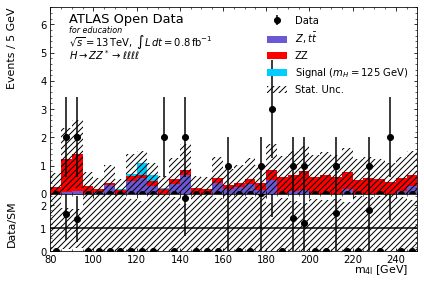

In [38]:
plot_data(data)